In [1]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy import signal
from scipy import linalg

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

dr = '../Recordings/Speller/'
file_1 = 'run_03.xdf'
file_2 = 'run_04.xdf'

# file 'run_03' contains data for spelling 'QUICK'
# file 'run_04' contains data for spelling 'P3EEG'

In [2]:
def speller_file_to_dict(data):
    run = {
        'data': [],
        'time_stamps': [],
        'aux': [],
        'aux_time_stamps': [],
        'markers': [],
        'marker_time_stamps': [],
        'sample_rate': {},
    }
    for stream in data:
        if stream['info']['name'][0] == 'eeg_data':
            run['data'] = stream['time_series']
            run['time_stamps'] = stream['time_stamps']
            run['sample_rate']['eeg'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'aux_data':
            run['aux'] = stream['time_series']
            run['aux_time_stamps'] = stream['time_stamps']
            run['sample_rate']['aux'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'P300_Speller_Markers':
            run['markers'] = stream['time_series']
            run['marker_time_stamps'] = stream['time_stamps']
        else:
            print('Warning unmatched stream name')
            
    return run

data = {
    'run': [],
}

for file_nm in [file_1, file_2]:
    imported_data, _ = pyxdf.load_xdf(dr+file_nm)
    run = speller_file_to_dict(imported_data)
    data['run'].append(run)
    
# print(data)

In [3]:
def plot_time_series(X, Y, labels, xlabel=None, ylabel=None, title=None, fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    for i in range(len(Y.T)):
        y = Y[:,i]
        ax.plot(X, y, label=labels[i])
        
    xlabel = xlabel if xlabel is not None else 'Time'
    ylabel = ylabel if ylabel is not None else 'Amplitude'
    title = title if title is not None else 'Time Series'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    _ = ax.legend()
    
    return fig, ax

def add_markers_to_plot(markers, time_stamps, fig, ax):
    for timestamp, marker in zip(time_stamps, markers):
#             if (marker[0] == '1'):
            if '[' in marker[0]:
                ax.axvline(x=timestamp, color='C1')

In [4]:
# =====================
# Re Reference all data
# =====================
def re_reference(session_data, new_ref_ch_idx):
    # returns data with the new reference channel removed... because its zeros
    new_ref = session_data[:,new_ref_ch_idx]
    re_referenced = session_data - new_ref[:,None]
    re_referenced = np.delete(re_referenced, new_ref_ch_idx, axis=1)
    
    return re_referenced

# =====================
# Epochs and windowing
# =====================
def ms_to_samples(duration, rate=250):
    return int((duration/1000.0) * rate)

# def get_samples_for_t_range(time_series, time_stamps, t_range, inclusive=False):
#     # great for grabbing a window
#     if inclusive:
#         low_filt = time_stamps >= t_range[0]
#     else:
#         low_filt = time_stamps > t_range[0]
        
#     high_filt = time_stamps < t_range[1]
#     index_range = low_filt == high_filt
#     data_range = time_series[index_range]
#     ts_range = time_stamps[index_range]
#     return data_range, ts_range

def get_epoch(data, data_times, stim_time, pre_stim_ms, post_stim_ms, sample_rate):
    # great for grabbing around a stimulus event time.
    
    # TODO: is there a faster way?
    i = (np.abs(data_times - stim_time)).argmin()
    start = i - ms_to_samples(pre_stim_ms, sample_rate)
    stop = i + ms_to_samples(post_stim_ms, sample_rate) + 1
    epoch = data[start:stop]
    
    return epoch


# ==========
# Epoch Prep
# ==========
def dc_offset(epoch_data, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    offset = np.mean(epoch_data, 0)

    return epoch_data - offset


def filter_eeg(epoch_data, sample_rate, f_range):
    # epoch_data should be 2D, (samples, channels)
    nyq = 0.5 * sample_rate
    low_limit = f_range[0] / nyq
    high_limit = f_range[1] / nyq
    
    sos = signal.butter(2, [low_limit, high_limit], btype='bandpass', output='sos')
    sig_filt = signal.sosfiltfilt(sos, epoch_data, axis=0)    
    
    return np.array(sig_filt)

def baseline_center(epoch_data, baseline_duration_ms, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    baseline_samples = ms_to_samples(baseline_duration_ms, sample_rate)
    pre_stimulus = epoch_data[:baseline_samples]
    baseline = np.mean(pre_stimulus, 0)
    
    return epoch_data - baseline


def prepare_epochs(epochs, sample_rate, baseline_duration=100):
    # epochs should be 3D, (event, samples, channels)
    # baseline duration, in ms
    
    prepped = []
    for epoch in epochs:
        temp_data = dc_offset(epoch, sample_rate)
#         temp_data = baseline_center(temp_data, baseline_duration, sample_rate)
        prepped.append(temp_data)
        
    return np.array(prepped)

# ================
# Speller Specific
# ================
ltr_key = ['ABCDEF',
           'GHIJKL',
           'MNOPQR',
           'STUVWX',
           'YZ1234',
           '56789_']

answer_key = {
    'Q': [3, 11],
    'U': [4, 9],
    'I': [2, 9],
    'C': [1, 9],
    'K': [2, 11],
    'P': [3, 10],
    '3': [5, 11],
    'E': [1, 11],
    'G': [2, 7],    
}

In [5]:
channels = ['ref', 'FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']
aux_chs = ['aux ch_1', 'aux ch_2', 'aux ch_3']

# assigning data... a bit redundant but the hope is to help make the pipelining easier
run_1 = data['run'][0]
run_2 = data['run'][1]

r1_eeg = run_1['data']
r1_eeg_ts = run_1['time_stamps']
r1_aux = run_1['aux']
r1_aux_ts = run_1['aux_time_stamps']
r1_markers = run_1['markers']
r1_markers_ts = run_1['marker_time_stamps']

r2_eeg = run_2['data']
r2_eeg_ts = run_2['time_stamps']
r2_aux = run_2['aux']
r2_aux_ts = run_2['aux_time_stamps']
r2_markers = run_2['markers']
r2_markers_ts = run_2['marker_time_stamps']

new_ref_ch_idx = 0
r1_eeg = re_reference(r1_eeg, new_ref_ch_idx)
r2_eeg = re_reference(r2_eeg, new_ref_ch_idx)
del channels[new_ref_ch_idx]

r1_eeg = filter_eeg(r1_eeg, 250, [0.1,20] )
r2_eeg = filter_eeg(r2_eeg, 250, [0.1,20] )

# remove Fp1 channel
# r1_eeg = np.delete(r1_eeg, -1, axis=1)
# r2_eeg = np.delete(r2_eeg, -1, axis=1)
# del channels[-1]

# convert times to int milliseconds
r1_eeg_ts = (r1_eeg_ts*1000).astype(int)
r2_eeg_ts = (r2_eeg_ts*1000).astype(int)
r1_aux_ts = (r1_aux_ts*1000).astype(int)
r2_aux_ts = (r2_aux_ts*1000).astype(int)
r1_markers_ts = (r1_markers_ts*1000).astype(int)
r2_markers_ts = (r2_markers_ts*1000).astype(int)

print(channels)
pz = channels.index('Pz')

['FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']


In [6]:
# HANDLE PHOTOSENSORS

# scaling
max_run1 = max(r1_aux[:,1])
max_run2 = max(r2_aux[:,1])
scaler = max_run2/max_run1
r1_aux[:,1] = r1_aux[:,1] * scaler

# clean and prep aux channel 0010010
# get associated markers and time stamps
# get trials of markers and time stamps
def get_ts_for_on_rise_threshold(data, data_ts, threshold):
    thr = (data > threshold) + 0
    rise = thr[1:] > thr[:-1]
    rise = np.insert(rise, 0, False) # accounts for lost position above
    return data_ts[rise]

PHOTO_SENSOR_THRESHOLD = 70 # this is based on a visual plot.
r1_photosensor_onsets = get_ts_for_on_rise_threshold(r1_aux[:,1], r1_aux_ts, PHOTO_SENSOR_THRESHOLD)
r2_photosensor_onsets = get_ts_for_on_rise_threshold(r2_aux[:,1], r2_aux_ts, PHOTO_SENSOR_THRESHOLD)


# We happen to know there are 600 stimulus onsets for these trials.
# 5 letters * 10 runs * 12 stimuli/rows_columns = 600
# TODO: automate this!
# There are 2 test sensor blinks that we can get rid of and there is a
# graphical blink at the very beginning of run 2 that needs to be removed.
r1_photosensor_onsets = r1_photosensor_onsets[2:]
r2_photosensor_onsets = r2_photosensor_onsets[3:]

def divide_markers(markers):
    # rc = row and column
    marker_collection = []
    target_collection = []
    y_collection = []
    for marker_arr in markers:
        marker = marker_arr[0]
        if '[' in marker:
            lbl = marker.split('[')[1].split(']')[0]
            target_collection.append(lbl)
            marker_collection.append([])
            y_collection.append([])
        elif marker.isnumeric():
            marker = int(marker)
            marker_collection[-1].append(marker)
            key = answer_key[target_collection[-1]]
            if marker in key:
                y_collection[-1].append(1)
            else:
                y_collection[-1].append(0)
                
    
    return target_collection, np.array(marker_collection), np.array(y_collection)

r1_target_ltr, r1_stim_markers, r1_y = divide_markers(r1_markers)
r2_target_ltr, r2_stim_markers, r2_y = divide_markers(r2_markers)

# print(r1_photosensor_onsets.shape)
# print(r1_stim_markers)
# print(r1_stim_markers.flatten().reshape((r1_stim_markers.shape)))
# print(r1_y.shape)
def sync_sensor_to_markers(sensor_ts, stim_markers, targets):
    len_a = len(sensor_ts.flatten())
    len_b = len(stim_markers.flatten())
    len_c = len(targets.flatten())
    assert len_a == len_b == len_c, 'Invalid Operation' # dimensions must match
    
    synced = np.vstack((sensor_ts.flatten(),
                        stim_markers.flatten(),
                        targets.flatten()))
    return synced.T
    
    
r1_events = sync_sensor_to_markers(r1_photosensor_onsets, r1_stim_markers, r1_y)
r2_events = sync_sensor_to_markers(r2_photosensor_onsets, r2_stim_markers, r2_y)
# (r1_events[:5,0] - r1_events[0,0])*1000
print(r1_events[:5])
print(r1_events.shape)


# clip all ts series to the same start and stop time.
# then r1_events could list sample position in master time
# ts = (r1_eeg_ts*1000).astype(int)

# start_time = min(min(r1_eeg_ts), min(r1_events[:,0]))
# r1_events[:,0]-start_time

# print(max(r1_eeg_ts))
# print(max(r2_eeg_ts))

[[1437429       5       0]
 [1437713       9       0]
 [1437997      10       0]
 [1438281       8       0]
 [1438565       1       0]]
(600, 3)


In [7]:
# Epoch durations in ms
PRE_STIM = 100
POST_STIM = 800

SAMPLE_RATE = 250.0 # Hz

# Make Epochs
r1_epochs = []
for time in r1_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r1_eeg, r1_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r1_epochs.append(epoch)
    
r2_epochs = []
for time in r2_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r2_eeg, r2_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r2_epochs.append(epoch)
    

# Prep Epochs
r1_epochs = prepare_epochs(r1_epochs, SAMPLE_RATE)
r2_epochs = prepare_epochs(r2_epochs, SAMPLE_RATE)
r1_epochs_ts = r1_photosensor_onsets
r2_epochs_ts = r2_photosensor_onsets

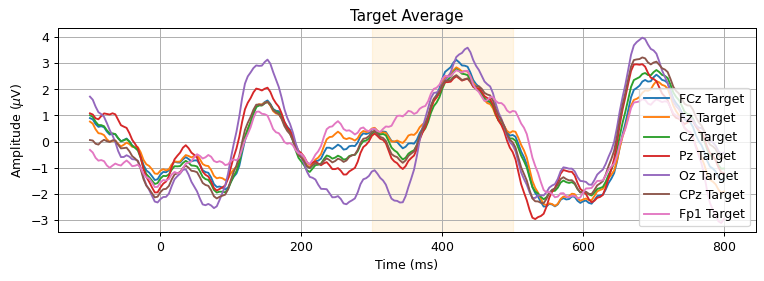

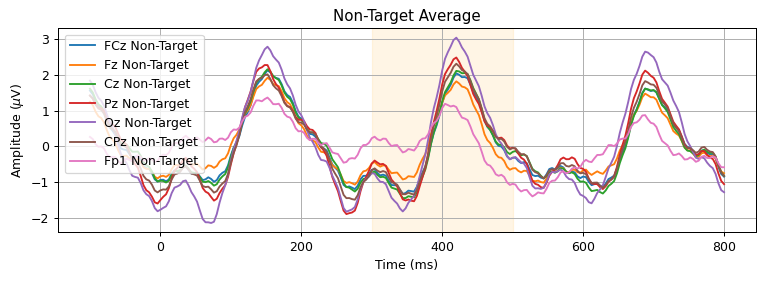

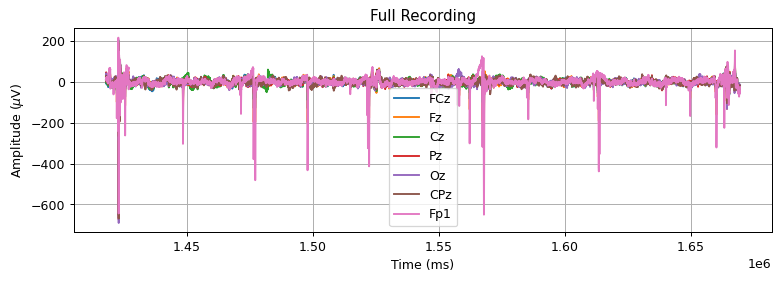

In [8]:
y = r1_events[:,2]
target_epochs = r1_epochs[y == 1]
non_target_epochs = r1_epochs[y == 0]

x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(r2_epochs.shape[1])]

target_epoch_avg = np.mean(target_epochs, axis=0)
non_target_epoch_avg = np.mean(non_target_epochs, axis=0)

g_labels = [ch + ' Target' for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    target_epoch_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = [ch + ' Non-Target' for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    non_target_epoch_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Non-Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = channels
fig, ax = plot_time_series(
    r1_eeg_ts,
    r1_eeg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Full Recording'
)
# _ = ax.axvspan(300, 500, color='orange', alpha=0.1)

session: 1429349 to 1657677


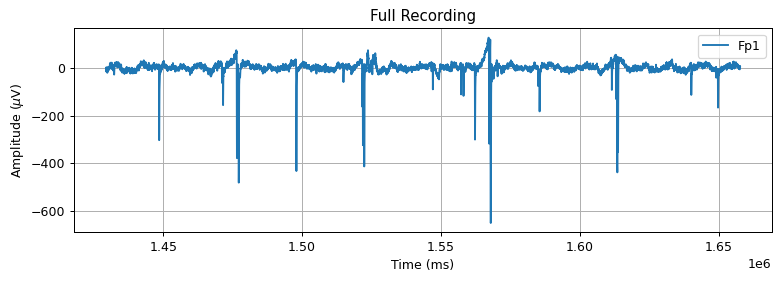

In [9]:
fp1 = channels.index('Fp1')
first_photosensor_time = r1_events[0,0]
first_marker_time = r1_markers_ts[1] # skip the first...its too early and not useful
last_photosensor_time = r1_events[-1,0]
last_marker_time = r1_markers_ts[-1]
session_win_start = min(first_photosensor_time, first_marker_time) - 1000
session_win_stop = max(last_photosensor_time, last_marker_time) + 1000
print(f'session: {session_win_start} to {session_win_stop}')
mask = (r1_eeg_ts >= session_win_start) & (r1_eeg_ts <= session_win_stop)


g_labels = ['Fp1']
fig, ax = plot_time_series(
    r1_eeg_ts[mask],
    r1_eeg[mask,fp1, None], # None == np.newaxis, adds axis
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Full Recording'
)

In [10]:
fp1_data = r1_eeg[mask,fp1]
fp1_data_ts = r1_eeg_ts[mask]
f_mean = fp1_data.mean()
f_std = fp1_data.std()
fp1_dev = np.abs((fp1_data - f_mean) / f_std)
print('blink samples...? :', np.count_nonzero(fp1_dev > 2.0))
blink_mask = fp1_dev > 1.5
blink_mask = blink_mask.astype(int)
blinks = []
for i, val in enumerate(blink_mask):
    if i == 0:
        continue
        
    prev = blink_mask[i-1]
    if val != prev:
        if val == 1:
            blinks.append([fp1_data_ts[i]])
        else:
            blinks[-1].append(fp1_data_ts[i])
            
blinks = np.array(blinks)
print(blinks.shape)

blink samples...? : 1224
(44, 2)


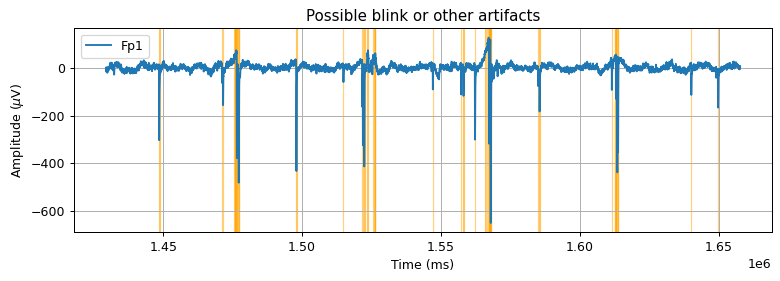

In [11]:
g_labels = ['Fp1']
fig, ax = plot_time_series(
    r1_eeg_ts[mask],
    r1_eeg[mask,fp1, None], # None == np.newaxis, adds axis
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Possible blink or other artifacts'
)
for blink in blinks:
    _ = ax.axvspan(blink[0], blink[1], color='orange', alpha=0.5)
    
# for e_time in r1_epochs_ts:
#     _ = ax.axvspan(e_time-PRE_STIM, e_time+POST_STIM, color='green', alpha=0.1)

In [12]:
count = 0
bad_epoch_i = []
for i, time in enumerate(r1_epochs_ts):
    e_start = time - PRE_STIM
    e_stop = time + POST_STIM
#     print(time, e_start, e_stop)
    a = (blinks[:,0] >= e_start) & (blinks[:,0] < e_stop)
    overlap = np.count_nonzero(a)
    if overlap == 0:
        b = (blinks[:,1] > e_start) & (blinks[:,1] <= e_stop)
        overlap = np.count_nonzero(b)
    
    if overlap > 0:
        bad_epoch_i.append(i)
        count += 1

bad_epoch_i = np.array(bad_epoch_i)
print(f'{count} contaminated epochs!')
# blinks.shape
print(bad_epoch_i)
print(r1_events[bad_epoch_i, 2])

36 contaminated epochs!
[ 34  35 107 108 109 166 167 168 220 221 222 298 299 330 331 332 333 334
 335 346 347 348 357 358 359 393 394 395 396 478 479 543 544 545 575 576]
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]


330 331


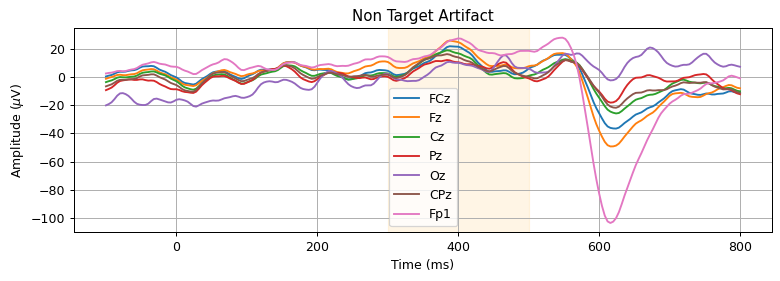

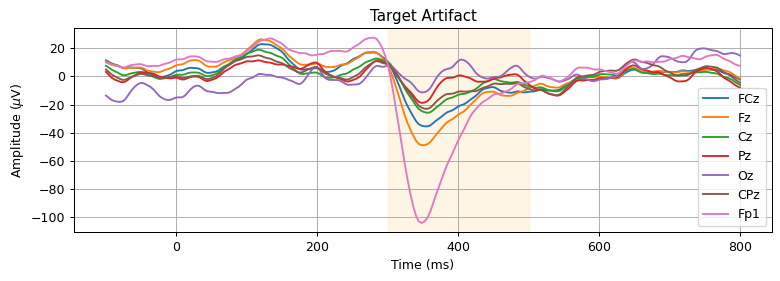

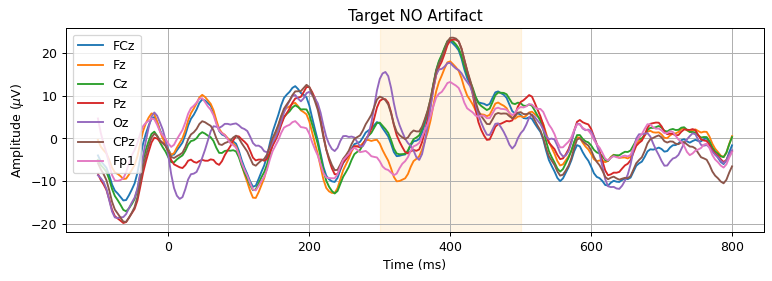

In [13]:
# y = r1_events[:,2]
# target_epochs = r1_epochs[y == 1]
# non_target_epochs = r1_epochs[y == 0]

b_nontarget = bad_epoch_i[13]
b_target = bad_epoch_i[14]
print(b_nontarget, b_target)
# print(r1_events[:100])
g_target = 19

x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(r2_epochs.shape[1])]

g_labels = channels
fig, ax = plot_time_series(
    x_for_plot,
    r1_epochs[b_nontarget],
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Non Target Artifact'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = channels
fig, ax = plot_time_series(
    x_for_plot,
    r1_epochs[b_target],
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Target Artifact'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = channels
fig, ax = plot_time_series(
    x_for_plot,
    r1_epochs[g_target],
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Target NO Artifact'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

In [14]:
def window_and_combine_features(epochs, sub_samples_per_ch, time_window):
    # epochs is expected to be 3D, (epoch, sample, channel)
    
    t_start = ms_to_samples(time_window[0], 250)
    t_len = ms_to_samples(time_window[1] - time_window[0], 250)
    
    window_len = np.round(t_len/sub_samples_per_ch).astype(int)
    windowed = np.zeros(( len(epochs), epochs.shape[-1], sub_samples_per_ch))
    
    for i in range(sub_samples_per_ch):
        win_start = i * window_len + t_start
        win_stop = win_start + window_len
        win_avg = np.mean(epochs[:,win_start:win_stop,:], axis=1) # (epochs x ch)
        windowed[:,:,i] = win_avg

    windowed = windowed.reshape((len(epochs), epochs.shape[-1] * sub_samples_per_ch))

    return windowed

def balance_zeros(data, y):
    # truncates the zeros down to the same size as ones.
    # assumes more zeros than ones
    zeros = np.sum(y == 0)
    ones = np.sum(y == 1)
    step = int(zeros/ones)
    print(f'{100*zeros/y.shape[0]:.2f}% zeros')
    sort_order = np.argsort(y, kind='stable')
    half_zeros = [i for i in range(0,zeros,step)]
    sort_order = np.concatenate((sort_order[half_zeros], sort_order[-ones:]), axis=0)
    orig_order = np.sort(sort_order)
    y_part = y[orig_order]
    data_part = data[orig_order]
    
    return data_part, y_part


mask = np.ones(len(r1_epochs), np.bool)
mask[bad_epoch_i] = 0

r1_epochs_clean = r1_epochs[mask]
r1_y_clean = r1_y.flatten()[mask]
r1_events_clean = r1_events[mask]

X, y = balance_zeros(r1_epochs_clean[:,:,:-1], r1_y_clean) # remove fp1
print(X.shape)
X_windowed = window_and_combine_features(X, 7, (200, 600))
print(X_windowed.shape)

82.98% zeros
(213, 226, 6)
(213, 42)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_windowed, y, test_size=0.20, random_state=40)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

Simple 20% test split accuracy: 0.6744186046511628


In [16]:
def test_LDA_prediction(target_ltrs, stim_labels, epochs, y, picks):
    for i, target_ltr in enumerate(target_ltrs):
        test_epoch = epochs[i][picks[i]]
        test_stim_labels = stim_labels[i][picks[i]]
        test_y = y[i][picks[i]]
        train_epochs = np.delete(epochs, i, 0)
        train_picks = np.delete(picks, i, 0)
        train_epochs = train_epochs[train_picks]
        train_stim_labels = np.delete(stim_labels, i, 0)
        train_stim_labels = train_stim_labels[train_picks]
        train_y = np.delete(y, i, 0)
        train_y = train_y[train_picks]
        
        shp = train_epochs.shape

        print('training shape:', shp)
        train_x = train_epochs
        
        train_x, train_y = balance_zeros(train_x, train_y)
        LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        LDA_clf = LDA_clf.fit(train_x, train_y)
        print(f'classifier score: {LDA_clf.score(test_epoch, test_y)}')
        
        confidence = LDA_clf.predict_proba(test_epoch)

        conf_avg = []
        for j in range(len(ltr_key)*2):
            avg = np.mean(confidence[test_stim_labels == j, 1])
            conf_avg.append(avg)
            
#         print(conf_avg)
            
        conf_avg_rows = conf_avg[:len(ltr_key)]
        conf_avg_cols = conf_avg[len(ltr_key):]
        
        max_row = np.argmax(conf_avg_rows)
        max_col = np.argmax(conf_avg_cols)
        print(f'-- Run: {i}, Results --')
        print(f'row choice: {max_row}, column choice: {max_col}')
        result = ltr_key[max_row][max_col]
#         print(result == target_ltr)
        print(result, target_ltr)
    
shp = r1_y.shape
bad_epoch_i_live = np.vstack((bad_epoch_i//shp[1], bad_epoch_i%shp[1])).T
r1_picks = np.ones(shp, bool)
r1_picks[bad_epoch_i_live[:,0],bad_epoch_i_live[:,1]] = 0

# remove fp1
r1_windowed = window_and_combine_features(r1_epochs[:,:,:-1], 7, (200, 600))
print(r1_windowed.shape)

epochs_by_target = r1_windowed.reshape(r1_y.shape + r1_windowed.shape[1:])
test_LDA_prediction(r1_target_ltr,
                    r1_stim_markers,
                    epochs_by_target,
                    r1_y,
                    r1_picks)

# epoched_index = np.arange(0,shp[0]*shp[1]).reshape(shp)

(600, 42)
training shape: (449, 42)
83.07% zeros
classifier score: 0.6695652173913044
-- Run: 0, Results --
row choice: 3, column choice: 0
S Q
training shape: (450, 42)
83.11% zeros
classifier score: 0.631578947368421
-- Run: 1, Results --
row choice: 2, column choice: 5
R U
training shape: (458, 42)
82.75% zeros
classifier score: 0.5188679245283019
-- Run: 2, Results --
row choice: 2, column choice: 5
R I
training shape: (450, 42)
83.11% zeros
classifier score: 0.5877192982456141
-- Run: 3, Results --
row choice: 2, column choice: 3
P C
training shape: (449, 42)
82.85% zeros
classifier score: 0.5739130434782609
-- Run: 4, Results --
row choice: 1, column choice: 1
H K


# xDAWN

$X=DA+N$

$X \in \mathbb{R}^{N_txN_s}$ matrix of recorded EEG signals.

$N_s$ = number of sensors

$N_t$ = number of temporal samples

$A\in \mathbb{R}^{N_exN_s}$ matrix of ERP signals.

$N_e$ = number of samples corresponding to the ERP ~600 milliseconds

$D\in \mathbb{R}^{N_txN_e}$ Toeplitz $T_k$ is the stimulus onset of the $k^{th}$ target stimulus

$N$ is the ongoing activity of the user's brain including artifacts

### least square estimation of A
$\hat{A}=\underset{A}{\mathrm{argmin}}{\lVert X-DA \rVert}_2^2$

$\hat{A}=(D^T D)^{-1} D^T X$

With classical epoching of $X$ to estimate $A$ leads to<br />
$A^{*} = D^T X$

### second idea
$XU=DAU+NU$

$U \in \mathbb{R}^{N_sxN_f}$

$N_f$ = spatial filters $\mathbf{u}_i$, the $i^{th}$ column of $U$ $(1\leq i \leq N_f \leq N_s)$

$\hat{A}=\Sigma \Delta \Pi^T$

$\Delta$ = nonnegative diagonal elements in decreasing order.<br />
signal and noise subspaces

$\Sigma = \begin{bmatrix} \Sigma_s & \Sigma_n \end{bmatrix}$

$\Delta = \begin{bmatrix} \Delta_s & 0 \\ 0 & \Delta_n \end{bmatrix}$

$\Pi = \begin{bmatrix} \Pi_s & \Pi_n \end{bmatrix}$

$U_{pca} = \Pi_s$

$\hat{A} = \Sigma_s \Delta_s \Pi_s^T + \Sigma_n \Delta_n \Pi_n^T$

$X = D A_{pca}^{'} W_{pca}^{T} + N^{'}$

$A_{pca}^{'} = \Sigma_s \Delta_s$ and $W_{pca}=\Pi_s$ iis the spatial distribution over sensors

$N'=N+D \Sigma_n \Delta_n \Pi_n^T$

>  Even if the PCA enhances the evoked potentials, the major drawback of this solution is that the noise N is not directly taken into account to estimate the spatial filters. Indeed, filtered signals are then obtained by

> $ \begin{aligned} \hat{S}_{pca} &= XU_{pca} \\ &= DA'_{pca} + N'U_{pca} \end{aligned}$

> where noisy term $N′ U_{pca} = N U_{pca}$ (since $\Pi_n$ and $\Pi_s$ are orthogonal) could also be largely amplified compared to noisy term $N$

#### overcoming the problem
use spatial filter $U$

$\hat{U} = \mathrm{arg}\underset{U}{\mathrm{max}} \frac{\text{Tr } (U^T \hat{A}^T D^T D \hat{A} U)}{\text{Tr } (U^T X^T X U)}$

again $U \in \mathbb{R}^{N_sxN_f}$

Using QR factorisation of $X$ and $D$ and replacing $\hat{A} with $\hat{A}=(D^T D)^{-1} D^T X$ the above $\hat{U}$ can be

$\hat{V} = \mathrm{arg}\underset{V}{\mathrm{max}} \frac{\text{Tr } (V^T Q_X^T Q_D Q_D^T Q_X V)}{\text{Tr } (V^T V)}$

with $V= R_X U$, $X = Q_X R_X$ and $D = Q_D R_D$

> Matrix $\hat{V}$ is the Rayleigh quotient and the solution is the concatenation of $N_f$ eigenvectors associated with the largest eigen values of matrix $Q_X^T Q_D Q_D^T Q_X$ and can be computed efficently with SVD of $Q_D^T Q_X$:

$Q_D^T Q_X = \Phi \Lambda \Psi^T$

$\Lambda \in \mathbb{R}^{N_sxN_s}$ diagonal matrix with singular values in descending order

$\Phi \in \mathbb{R}^{N_exN_s}$ and $\Psi \in \mathbb{R}^{N_sxN_s}$ are two column orthonormal matrices

$\Psi = \begin{bmatrix} \Psi_s & \Psi_n \end{bmatrix}$

$\Lambda = \begin{bmatrix} \Lambda_s & 0 \\ 0 & \Lambda_n \end{bmatrix}$

$\Psi = \begin{bmatrix} \Psi_s & \Psi_n \end{bmatrix}$

leads to $\hat{V} = \Psi_s$

the solution <br />
$\hat{U} = R_X^{-1} \Psi_s$

$\hat{A} = R_D^{-1} \Phi_s \Lambda_s \Psi_s^T R_X + R_D^{-1} \Phi_n \Lambda_n \Psi_n^T R_X$

> thanks to the QR decomposition of D and X, and by using SVD expression of QT QX (11). Model (1) is finally expressed as

$X = DA'W^T+N'$

where <br />
$A' = R_D^{-1} \Phi_s \Lambda_s$ <br />
$W = R_X^T \Psi_s$

> $A'$ is the synchronous response of reduced dims, $W$ is the spatial distribution over sensors, and $N' = N + DR_D^{-1} \Phi_n \Lambda_n \Psi_n^T R_X$ is the noise term. The $I$ dimensional evoked subspace is thus defined by the $I$ couples $(\hat{\mathbf{u}}_i,\hat{\mathbf{a}}'_i)$


### enhanced signals are computed

$ \begin{aligned} \hat{S} &= X\hat{U} \\ &= DA' + N'R_X^{-1} \Psi_s \end{aligned}$

---
## algorithm for xDAWN , estimate evoked subspace.
---
1. Compute QR factorisation of $X \Rightarrow X = Q_X R_X$
2. Compute QR factorisation of $D \Rightarrow D = Q_D R_D$
3. Compute SVD of $Q_D^T Q_X \Rightarrow Q_D^T Q_X = \Phi \Lambda \Psi^T$
4. Select the $I$ couples of singular vectors $(\Phi_i, \Psi_i)$ associated with the $I$ largest singular values $\lambda_i$
5. Finally $\forall 1 \leq i \leq I$, $(\hat{\mathbf{u}}_i,\mathbf{a}'_i) = (R_X^{-1} \psi_i, R_D^{-1} \phi_i \lambda_i)$
6. Estimate sources: $\forall 1 \leq i \leq I$, $\hat{s}_i(t) = \hat{\mathbf{u}}_i^T \mathbf{x}(t)$
---

In [30]:
def get_closest_ts_index(data_ts, stim_time):
    i = (np.abs(data_ts - stim_time)).argmin()
    return i

REMOVE_FP1 = True

# X is the eeg recording (n_samples, n_channels)
first_photosensor_time = r1_events[0,0]
first_marker_time = r1_markers_ts[1] # skip the first...its too early and not useful
last_photosensor_time = r1_events[-1,0]
last_marker_time = r1_markers_ts[-1]
session_win_start = min(first_photosensor_time, first_marker_time) - 1000
session_win_stop = max(last_photosensor_time, last_marker_time) + 1000
r1_mask = (r1_eeg_ts >= session_win_start) & (r1_eeg_ts <= session_win_stop)
if REMOVE_FP1:
    X = r1_eeg[r1_mask,:-1]
else:
    X = r1_eeg[r1_mask]
    
ts = r1_eeg_ts[r1_mask]

# D toeplitz of target stimuli, (n_samples, n_erps_assoc_samples) # 600 ms
target_stim = r1_events[r1_events[:,2] == 1]
n_e = ms_to_samples(duration=600, rate=SAMPLE_RATE)
n_t = len(X)
first_col = np.zeros((n_t))
target_index = [get_closest_ts_index(ts, e[0]) for e in target_stim]
first_col[target_index] = 1
first_row = np.zeros((n_e))
D = linalg.toeplitz(first_col, first_row)

# 1.
Q_X, R_X = linalg.qr(X, mode='economic')
# 2.
Q_D, R_D = linalg.qr(D, mode='economic')
# 3.
# U, s, Vh = linalg.svd(Q_D.T @ Q_X, full_matrices=False)
phi, lam, psi = linalg.svd(Q_D.T @ Q_X, full_matrices=False)
print(phi.shape, lam.shape, psi.shape)

# 4.
n_f = 3
phi_i = phi[:,0:n_f]
psi_i = psi[:,0:n_f]

# 5.
filters = []
for i in range(n_f):
    u_i = linalg.inv(R_X) @ psi_i[:,i]
    filters.append(u_i)
    
filters = np.array(filters)
print(filters.shape)

# 6.
S_i = []
for i in range(n_f):
#     s_i = filters[i,np.newaxis].T @ X
    s_i = filters[i,np.newaxis] @ X.T
    S_i.append(s_i)
    
S_i = np.array(S_i).reshape((n_f, n_t)).T
S_i.shape

(150, 6) (6,) (6, 6)
(3, 6)


(57083, 3)

In [31]:
def plot_epochs(ch_epochs, xlabel='Epochs', ylabel='Times (ms)', title='Epoch Comparison', tmin=None, tmax=None):
#     if fig is None and ax is None:
    fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    if tmin == None or tmax == None:
        tmin = 0
        tmax = ch_epochs.shape[-1]
    extent = [tmin, tmax, 0, len(ch_epochs)]
    
    plot = ax.matshow(ch_epochs, interpolation='nearest', origin='lower', aspect='auto', extent=extent)

    ax.xaxis.set_ticks_position("bottom")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.axis('auto')
    ax.axis('tight')
    ax.axvline(0, color='k', linewidth=1, linestyle='--')

    cbar = fig.colorbar(plot)
    cbar.ax.set_ylabel(r'Amplitude ($\mu$V)', rotation=270, labelpad=12)
    
    return fig, ax

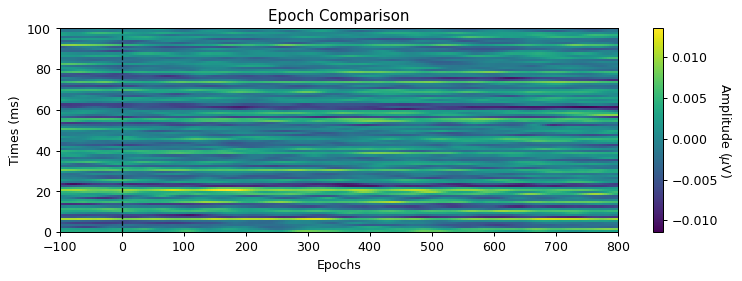

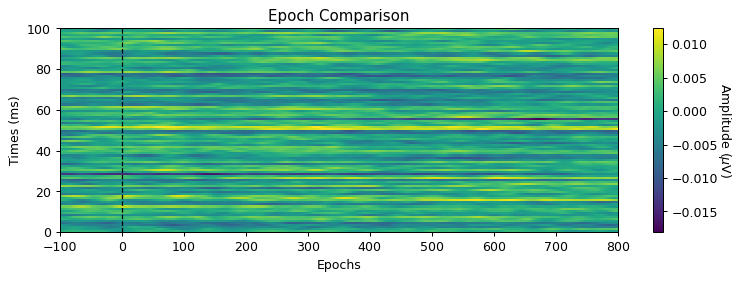

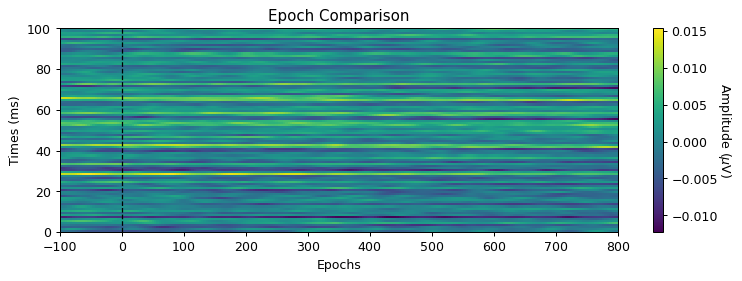

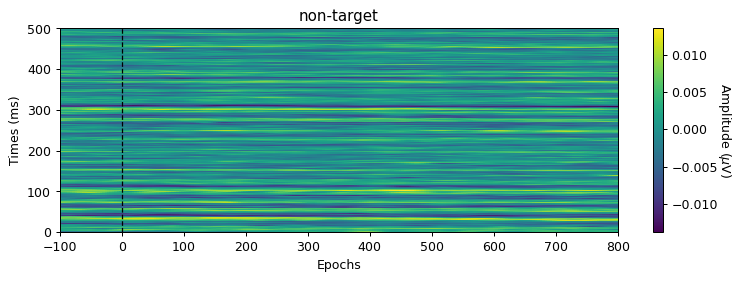

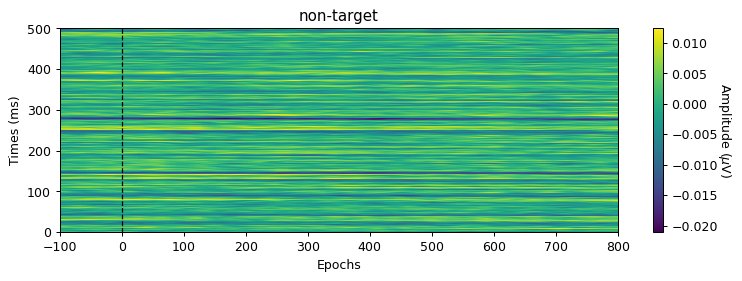

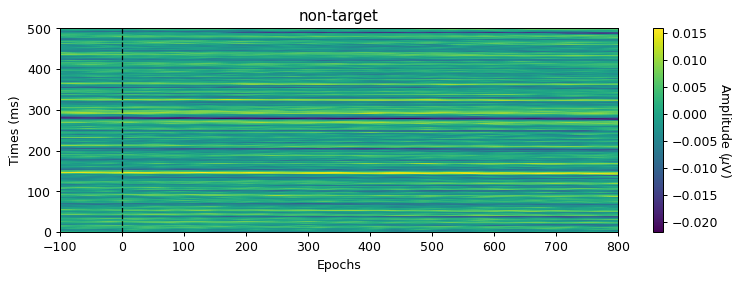

In [32]:
s_epochs = []
for event in r1_events:
    epoch = get_epoch(S_i, ts, event[0], PRE_STIM, POST_STIM, SAMPLE_RATE)
    s_epochs.append(epoch)
    
s_epochs = np.array(s_epochs)
target_s_epochs = s_epochs[r1_events[:,2] == 1]
# target_s_epochs.shape
for i in range(n_f):
    plot_epochs(target_s_epochs[:,:,i], tmin=-100, tmax=800)
    
nontarget_s_epochs = s_epochs[r1_events[:,2] == 0]
# target_s_epochs.shape
for i in range(n_f):
    plot_epochs(nontarget_s_epochs[:,:,i], title='non-target', tmin=-100, tmax=800)

In [33]:
shp = r1_y.shape
bad_epoch_i_live = np.vstack((bad_epoch_i//shp[1], bad_epoch_i%shp[1])).T
r1_picks = np.ones(shp, bool)
r1_picks[bad_epoch_i_live[:,0],bad_epoch_i_live[:,1]] = 0

# remove fp1
# r1_windowed = window_and_combine_features(s_epochs[:,:,:-1], 7, (200, 600))
r1_windowed = window_and_combine_features(s_epochs, 7, (200, 600))
print(r1_windowed.shape)

epochs_by_target = r1_windowed.reshape(r1_y.shape + r1_windowed.shape[1:])
test_LDA_prediction(r1_target_ltr,
                    r1_stim_markers,
                    epochs_by_target,
                    r1_y,
                    r1_picks)

(600, 21)
training shape: (449, 21)
83.07% zeros
classifier score: 0.7130434782608696
-- Run: 0, Results --
row choice: 3, column choice: 0
S Q
training shape: (450, 21)
83.11% zeros
classifier score: 0.7192982456140351
-- Run: 1, Results --
row choice: 4, column choice: 4
3 U
training shape: (458, 21)
82.75% zeros
classifier score: 0.5943396226415094
-- Run: 2, Results --
row choice: 2, column choice: 1
N I
training shape: (450, 21)
83.11% zeros
classifier score: 0.631578947368421
-- Run: 3, Results --
row choice: 1, column choice: 4
K C
training shape: (449, 21)
82.85% zeros
classifier score: 0.6521739130434783
-- Run: 4, Results --
row choice: 4, column choice: 1
Z K


In [34]:
mask = np.ones(len(r1_epochs), np.bool)
mask[bad_epoch_i] = 0

s_epochs_clean = s_epochs[mask]
r1_y_clean = r1_y.flatten()[mask]
r1_events_clean = r1_events[mask]

X_s, y_s = balance_zeros(s_epochs_clean, r1_y_clean)
print(X_s.shape)
X_windowed = window_and_combine_features(X_s, 7, (200, 600))
print(X_windowed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_s, test_size=0.20, random_state=40)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

82.98% zeros
(213, 226, 3)
(213, 21)
Simple 20% test split accuracy: 0.6046511627906976


In [ ]:
test = D.T@X
D.shape

In [ ]:
# toeplitz           data
# [1 0 0 0 0 0 0 0] [2 3 4]
# [0 1 0 0 0 0 0 0] [1 4 2]
# [0 0 1 0 0 0 0 0] [6 2 7]
# [0 0 0 1 0 0 0 0] [1 1 3]
# [0 0 0 0 1 0 0 0] [7 5 8]
# [0 0 0 0 0 1 0 0] [8 4 2]
# [0 0 0 0 0 0 1 0] [1 1 1]
# [0 0 0 0 0 0 0 1] [2 2 2]
# [0 0 0 0 0 0 0 0] [3 3 3]
# [0 0 0 0 0 0 0 0] [4 4 4]
# 10,8 10,3

# D.T*X

# result
# [2 3 4]
# [1 4 2]
# [6 2 7]
# [1 1 3]
# [7 5 8]
# [8 4 2]
# [1 1 1]
# [2 2 2]
# 8,3

# D_1*P_1
# 5000,100 X 100,7

# P_1 = a_1*w_1.T
# 100,1 X 1,7 = 100,7 
# a_1 is the temporal pattern
# w_1 is the spatial distribution over the sensors